# Predicting loan default 

**Submitted by:**

Alex Arasanz (S.Nr : 2073586)

Arturo Rico (S.Nr : 2030589)

## Table of Contents

1. [Introduction](##Introduction)

    1.2 [Motivation](#Motivation)

    1.3 [Research question](#Research%question)

2. [Data](#Data)

    2.1 [Importing data](#Import)

    2.2 [Merge and data manipulation](#Manipulation)
   
    2.3 [Resampling](#Resampling)
    
3. [Method](#Method)  

    3.1 [Neural Networks](#Neural)
    
    3.2 [Bayes Model](#Bayes)
    
    3.3 [Preview of answers](#Preview%of%answers)

4. [Modelling the Neural Network](#Modelling)

    4.1 [Neural Network structure](#Structure)
    
    4.2 [Testing different activation functions](#Activation)
    
    4.3 [Testing explanatory variables](#Variables)
    
    4.4 [Testing over and undersampling](#OverUnder)
    
5. [Bayes Analysis](#Bayes)

    5.1 [Bayesian analysis with simulated data](#Simulated)
    
    5.2 [Bayesian analysis with real banking data](#Real)

6. [Discussions and conclusions](#Discussions%and%conclusions)


## 1. Introduction

This is the final assignment of the Data Science for Economists seminar. In this project we aim to model and predict loan default through Neural Networks and understand the determinants of it through a Bayesian Analysis. 

### 1.1 Motivation

When banks just have a few pieces of information, predicting how likely a client is to default on a loan is always an interesting and tough topic. Banking data science teams use machine learning techniques to create prediction models in the modern day. They are most likely to employ private datasets that are collected internally as part of their day-to-day operations. Therefore, there are not many public real-world datasets we can use to work on financial projects. There is, however, an exception: the Berka Dataset.

### 1.2 Research question

1. Can we predict loan default?

2. What are the determinants of loan default? 

## 2. Data

The Berka Dataset, also named the PKDD’99 Financial Dataset, is a collection of real anonymized financial information from a Czech bank, that was utilized for PKDD’99 Discovery Challenge.

### 2.1. Importing data

The entire dataset is made up of eight separate datasets that track different pieces of data.

**Enviroment**

In [1]:
# Importing required modules
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import optimize
import pymc3 as pm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from pickle import dump, load
import imblearn
from sklearn.metrics import confusion_matrix, classification_report
from numpy.random import seed
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
# Bayesian
import arviz as az
import graphviz



WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#Import data
account_df = pd.read_csv('account.csv', delimiter = ';')
card_df = pd.read_csv('card.csv', delimiter = ';')
client_df = pd.read_csv('client.csv', delimiter = ';')
disp_df = pd.read_csv('disp.csv', delimiter = ';')
district_df = pd.read_csv('district.csv', delimiter = ';')
loan_df = pd.read_csv('loan.csv', delimiter = ';')
order_df = pd.read_csv('order.csv', delimiter = ';')
trans_df = pd.read_csv('trans.csv', delimiter = ';', low_memory=False)


### 2.2. Merge and data manipulation

In order to treat the entire dataset, we must first merge each of the individual files. The composition of the whole dataset and how each of the different datasets are connected through key variables can be seen in the following diagram.

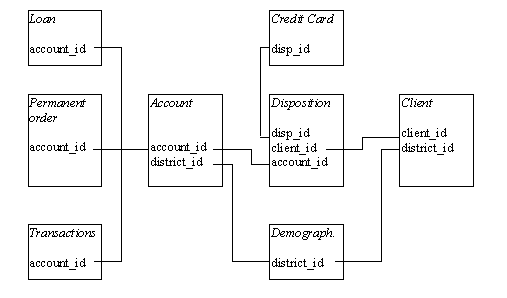

In [41]:
from PIL import Image, ImageChops
from PIL.GifImagePlugin import getheader, getdata
Image.open('data map.gif') 

Before merging the files, some data manipulation needs to be done in order to homogenize the name of the variables across datasets.

In [3]:
# new column names
account_df = account_df.rename(columns={"date":"date_account"}) # Date of the account's creation
loan_df = loan_df.rename(columns={"date":"date_loan"}) # Date when the loan was granted
loan_df = loan_df.rename(columns={"amount":"amount_loan"}) # Amount of loan
loan_df = loan_df.rename(columns={"duration":"duration_loan"}) # Duration of loan
loan_df = loan_df.rename(columns={"payments":"payments_loan"}) # Monthly Payments on Loan
loan_df = loan_df.rename(columns={"status":"status_loan"}) # Status of Loan
trans_df = trans_df.rename(columns={"amount":"amount_transaction"}) # Amount of transaction
trans_df = trans_df.rename(columns={"date":"date_transaction"}) # Date of transaction
trans_df = trans_df.rename(columns={"type":"type_transaction"}) # Type of transaction
trans_df = trans_df.rename(columns={"account":"account_partner_trans"}) # Account of the partner
trans_df = trans_df.rename(columns={"bank":"bank_partner_trans"}) # Bank of the partner
trans_df = trans_df.rename(columns={"balance":"balance_trans"}) # Balance of Account after Transaction
trans_df = trans_df.rename(columns={"k_symbol":"k_symbol_trans"}) # Characterization of Transaction
order_df = order_df.rename(columns={"amount":"amount_order"}) # Amount debited from order account
order_df = order_df.rename(columns={"k_symbol":"k_symbol_order"}) # Characterization of the payment
card_df = card_df.rename(columns={"type":"type_card"}) # Type of card
card_df = card_df.rename(columns={"issued":"issued_card"}) # Date card was issued
district_df = district_df.rename(columns={"A1":"district_id"}) # District identifier

**Merging dataframes**

Now, we can proceed to the merge of the dataframes. We will use the inner method obtains the intercept between the dataframes that are merged.

In [4]:
# Merger
df_merge_1 = account_df.merge(loan_df,how='inner',left_on=['account_id'], right_on=['account_id'])

In [5]:
df_merge_2 = df_merge_1.merge(order_df,how='inner',left_on=['account_id'], right_on=['account_id'])

In [6]:
df_merge_3 = df_merge_2.merge(trans_df,how='inner',left_on=['account_id'], right_on=['account_id'])

In [7]:
df_merge_4 = df_merge_3.merge(disp_df,how='inner',left_on=['account_id'], right_on=['account_id'])

In [8]:
df_merge_5 = df_merge_4.merge(card_df,how='inner',left_on=['disp_id'], right_on=['disp_id'])

In [9]:
df_merge_6 = df_merge_5.merge(district_df,how='inner',left_on=['district_id'], right_on=['district_id'])

In [10]:
df_merge_7 = df_merge_6.merge(client_df,how='inner',left_on=['district_id','client_id'], right_on=['district_id','client_id'])

In the following histogram we can see a summary of the distribution of our outcome variable; status loan.

<AxesSubplot:xlabel='status_loan', ylabel='count'>

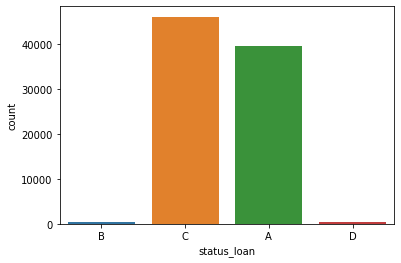

In [51]:
sns.countplot(x="status_loan", data=df_merge_7) # seaborn package to count number of observations per status loan

**Creating days between variable**

*Days between* is a variable that shows the time gap between creating the account and applying for the loan. This is not explicitly in the original dataset but we believe may be a good predictor of loan default

In [11]:
df_merge_7["days_between"] = df_merge_7["date_loan"] - df_merge_7["date_account"] #define var days between

**Binary classes defined by recoding c and d**

Since predicting the loan default is a binary classification problem, we first need to know how many instances in each class. By looking at the status variable in the Loan table, there are 4 distinct values: A, B, C, and D.

A: Contract finished, no problems.
B: Contract finished, loan not paid.
C: Running contract, okay so far.
D: Running contract, client in debt.

Binary classes are defined as: good (A or C) or bad (B or D) as follows:

In [12]:
df_merge_7['status_loan'] = df_merge_7['status_loan'].replace(['C'], 'A') #replace C status for A

In [13]:
df_merge_7['status_loan'] = df_merge_7['status_loan'].replace(['D'], 'B') #replace D status for A

**Coding status loan: dummy variable**

Once we created a dummy variable with only two categories; A or B, now we need to encode it as a dummy in order to be able to use it.

In [15]:
df_merge_7 = pd.get_dummies(df_merge_7,columns=["status_loan"],drop_first=True) #Create dummy variable

To check for any imbalances in our default variable:

In [16]:
df_merge_7.groupby("status_loan_B")["status_loan_B"].count()

status_loan_B
0    85735
1      931
Name: status_loan_B, dtype: int64

The default loan variable is imbalanced and this affect our prediction capacity. We therefore consider resampling for a robustness analysis.

### 2.3 Resampling

There are two approaches to make a balanced dataset out of an imbalanced one are under-sampling and over-sampling.

**Dataset oversampling:**

Oversampling is normally used when the quantity of data is insufficient. It tries to balance the dataset by increasing the size of rare samples

In [17]:
count_class_0, count_class_1 = df_merge_7["status_loan_B"].value_counts() #Define count number for status
df_0 = df_merge_7[df_merge_7['status_loan_B'] == 0] #Define sample for status no default
df_1 = df_merge_7[df_merge_7['status_loan_B'] == 1] #Define sample for status default
df_1_over = df_1.sample(count_class_0, replace=True) #Resample sample status default based on no default count
df_test_over = pd.concat([df_0, df_1_over], axis=0) #Put back together
print('Random over-sampling:')
print(df_test_over['status_loan_B'].value_counts())

Random over-sampling:
0    85735
1    85735
Name: status_loan_B, dtype: int64


<AxesSubplot:xlabel='status_loan_B', ylabel='count'>

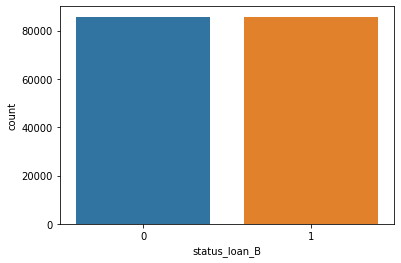

In [18]:
sns.countplot(x="status_loan_B", data=df_test_over)

**Dataset Undersampling:**

On the other hand, under-sampling balances the dataset by reducing the size of the abundant class. This method is used when the quantity of data is sufficient.

In [19]:
from imblearn.under_sampling import RandomUnderSampler

In [59]:
undersample = RandomUnderSampler(sampling_strategy='majority') #Stablish majority as method for (under)resampling 

In [21]:
X = df_merge_7[['amount_loan', 'duration_loan', 'payments_loan', 'account_to', 'amount_order',
                   'amount_transaction', "days_between", 'balance_trans', 'A4',
                   'A9', 'A10', 'A11', 'A13', 'A14',  'A16']] #Use a subset of variables that can potentially predict loan default 
y = df_merge_7['status_loan_B'] #define variable to predict

X_under, y_under = undersample.fit_resample(X,y) #Apply undersampling method

In this case we directly split the sample between X_under and y_under to later use it for the neural network composition.

In [25]:
print(y_under.value_counts())

0    931
1    931
Name: status_loan_B, dtype: int64


The sample is now balanced

## 3. Method

As already introduced before, in this project we build different predicting default models through Neural Networks and we perform a Bayes analysis to understand the determinants of loan default.

### 3.1. Neural Networks

Neural network is a machine learning method which consist on a set of algorithms that attempt to emulate the human brain by determining the relationship between pieces of data. It's employed in a variety of applications, including regression, prediction, classification, and image recognition, among others.

A neural network includes several layers, each of which performs a specialized function. As the model's complexity grows, the number of layers grows as well, which is why it's called a multi-layer perceptron.

A neural network in its purest form includes three layers: an input layer, a hidden layer, and an output layer. The input layer receives the input signals and passes them on to the next layer, with the output layer delivering the final prediction. These neural networks, like machine learning methods, must be taught with some training data before being used to solve a specific problem.

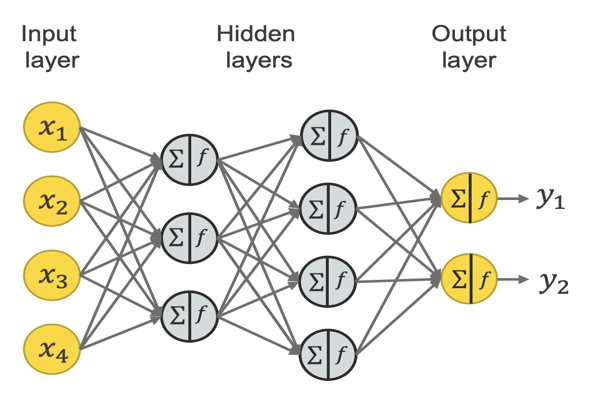

In [37]:
from PIL import Image, ImageChops
from PIL.GifImagePlugin import getheader, getdata
image = Image.open('neural_networks.png') 
new_image = image.resize((600, 400)) #Resize image
new_image

**Assumptions:**

1. Artificial Neurons are arranged in layers, which are sequentially arranged.
2. Neurons within the same layer do not interact or communicate to each other.
3. All inputs enter into the network through the input layer and passes through the output layer.
4. All hidden layers at same level should have same activation function.
5. Artificial neuron at consecutive layers are densely connected.
6. Every inter-connected neural network has it’s own weight and biased associated with it.

### 3.2. Bayesian analysis

Bayesian analysis is a method of statistical inference that allows to combine prior information about a population parameter to be combined evidence from information contained in a sample to guide the statistical inference process. The first step is to specify a prior probability distribution for a parameter of interest. After that, the evidence is gathered and pooled using Bayes' theorem to produce a posterior probability distribution for the parameter. The posterior distribution is used to make statistical inference about a parameter.

#### Bayes formula

\begin{equation}
\label{eq:4}
Prob(prior|data) = \frac{P(prior|data)*P(prior)}{P(data)}
\end{equation}

**Assumptions:**

The implicit assumptions of a bayesian analysis depends on the usage and interpretation that ones wants to take. In our case, since we aim to use it to understand the determinants of loan default, the basic simple regression assumptions apply. 

1. There is a linear and additive relationship between the outcome variable and the predictor variables. An additive relationship implies that the effect of X on Y is independent of other variables. That is, precictors are fully exogenous.
2. There is no autocorrelation; correlation between the residual (error) terms.
3. There is no multicollinearity; independent variables should not be correlated.
4. The error terms has constant variance and hence there is homoskedasticity. 
5. The error terms is normally distributed.
6. The likelihood function that we choose is a reasonable representation of the data.

### 3.4. Preview of answers

*Research question 1:* We expect to create an accurate prediction model for loan default given the large amount and quality of variables we have.

*Research question 2:* We expcept to recover the true underlying determinant parameters for loan default. However, we understand that the interpretation is limited. No causal inference will be infered through the bayesian analysis. 

## 4. Modelling the neural network

In this section we perfom different neural networks to find the best predictive model for loan default. We first explore different neural network structures. Then we test different subsets of explanatory variables. And finally we analyse the impact of under and over sampling. All these different specifications, at the same time, serve as a robustness analysis.

The first step in a training a machine learning model is to split a train and test sets. It is tricky in our dataset because it is not balanced: there are almost 10 times more good loans than bad loans. A stratified split is a good option here because it preserves the ratio between classes in both train and test sets.

**Split sample**

Sampling between training and test data allows the neural network to perform based on trial and error and then validate the findings.

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                            stratify=y, random_state=101) #Split sample in training and test sets

### 4.1. Neural Network structure

**Baseline Model**

- We use the Sigmoid activation method given that it is used for binary classification in the Logistic Regression model.
- We use ReLu activation method because is one the most advanced and commonly used for hidden layers, compared to the sigmoid and TanH. We also tried an specification with two hidden layers with 'tahn' activation method and obtained a slower stabilization of the loss in both training and validation sets, and therefore stick to ReLu.
- Batch size: iterations to update the weight. The lower it is, the higher the stability of the neural network but the longer it takes to train.
- More layers leads to faster stabilization (conversion to a loss of 0).
- Different activation method for hidden layers leads to slower convergence.

**Neural Network 1: one hidden layer**

In [70]:

seed(1)
tf.random.set_seed(1234) #Set seed for reproducibility

#Scaling our traning and test data sets
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Defining the model
model = Sequential()
model.add(Dense(15, activation='relu')) #input layers
model.add(Dense(5, activation='relu')) #hidden layers
model.add(Dense(1, activation='sigmoid')) #output layer
model.compile(
        optimizer='adam', #adam optimizer is commonly used in this types of prediction
        loss='binary_crossentropy', #given that we are predicting a binary variable
        metrics=['accuracy']) # accuracy as metric
early_stop = EarlyStopping( #Stop training when a monitored metric has stopped improving
        monitor='val_loss', #This metric is validation loss
        mode='min', #In min mode, training will stop when the quantity monitored has stopped decreasing
        verbose=1, #Mode 1 displays messages when the callback takes an action
        patience=25) #Number of epochs with no improvement after which training will be stopped

history = model.fit( #Safe the iterations history after fitting the model for plotting
        X_train, #data sets for training 
        y_train, #data sets for training
        epochs=50, #Adjust Number of epochs (iterations with samples) that enables loss reduction 
        batch_size=256, #iterations to update the weight
        validation_data=(X_test, y_test),
         callbacks=[early_stop])

Epoch 1/50
237/237 [==============================] - 1s 3ms/step - loss: 0.3316 - accuracy: 0.8960 - val_loss: 0.0876 - val_accuracy: 0.9893
Epoch 2/50
237/237 [==============================] - 1s 2ms/step - loss: 0.0771 - accuracy: 0.9893 - val_loss: 0.0705 - val_accuracy: 0.9893
Epoch 3/50
237/237 [==============================] - 1s 2ms/step - loss: 0.0671 - accuracy: 0.9893 - val_loss: 0.0619 - val_accuracy: 0.9893
Epoch 4/50
237/237 [==============================] - 1s 2ms/step - loss: 0.0594 - accuracy: 0.9893 - val_loss: 0.0555 - val_accuracy: 0.9893
Epoch 5/50
237/237 [==============================] - 1s 2ms/step - loss: 0.0542 - accuracy: 0.9893 - val_loss: 0.0508 - val_accuracy: 0.9893
Epoch 6/50
237/237 [==============================] - 0s 2ms/step - loss: 0.0499 - accuracy: 0.9893 - val_loss: 0.0463 - val_accuracy: 0.9893
Epoch 7/50
237/237 [==============================] - 1s 2ms/step - loss: 0.0454 - accuracy: 0.9893 - val_loss: 0.0414 - val_accuracy: 0.9893
Epoch 

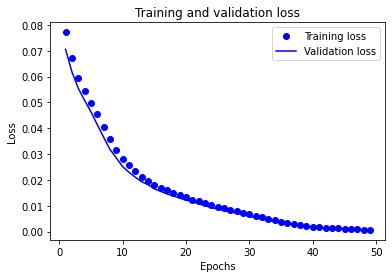

In [71]:
loss = history.history['loss'][1:] # loss for each epoch history
val_loss = history.history['val_loss'][1:] #retrieve history for iterations with the validation (test) set 

epochs = range(1, len(loss)+1) # define x axis

# Define plot parameters
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Based on the training and validation loss graph, we can see that there is no evidence of overfitting nor underfitting. Moreover the NN converges at 40-50. 

In [72]:
predictions = model.predict_classes(X_test) #retrieve predictions 

print(
        confusion_matrix(y_test,predictions), #create confusion matrix showing type 1 and 2 errors
        '\n', 
        classification_report(y_test,predictions) #show classification report with the statistics of the model
)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[[25721     0]
 [    0   279]] 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     25721
           1       1.00      1.00      1.00       279

    accuracy                           1.00     26000
   macro avg       1.00      1.00      1.00     26000
weighted avg       1.00      1.00      1.00     26000



We initially tried with a batch size of 512 and found a type 2 error of 57 observations (that reported no default when there was default) out of 279 (those who actually defaulted). This could be due to the fact that the batch size affects the stability of the results produced by the neural network (the smaller the batch size, the less volatile). After running the neural network with a smaller batch size (256), we found more stable results. We therefore use this batch size for the rest of the specifications.

We now include more layers to increase the efficiency of the Neural Network without compromising the accuracy. 

**Neural Network 2: two hidden layer**

In [73]:
#Set seed for reproducibility
seed(1)
tf.random.set_seed(1234)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(15, activation='relu')) #input layers
model.add(Dense(10, activation='relu')) #hidden layers
model.add(Dense(5, activation='relu')) #hidden layers
model.add(Dense(1, activation='sigmoid')) #output layer
model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy'])
early_stop = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        verbose=1, 
        patience=25)

history = model.fit(
        X_train, 
        y_train, 
        epochs=20, 
        batch_size=256, # Higher batch size results in a higher type 2 error
        validation_data=(X_test, y_test),
         callbacks=[early_stop])

Epoch 1/20
237/237 [==============================] - 1s 3ms/step - loss: 0.1608 - accuracy: 0.9891 - val_loss: 0.0761 - val_accuracy: 0.9893
Epoch 2/20
237/237 [==============================] - 0s 2ms/step - loss: 0.0678 - accuracy: 0.9893 - val_loss: 0.0597 - val_accuracy: 0.9893
Epoch 3/20
237/237 [==============================] - 1s 2ms/step - loss: 0.0530 - accuracy: 0.9893 - val_loss: 0.0448 - val_accuracy: 0.9893
Epoch 4/20
237/237 [==============================] - 0s 2ms/step - loss: 0.0379 - accuracy: 0.9893 - val_loss: 0.0291 - val_accuracy: 0.9893
Epoch 5/20
237/237 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9895 - val_loss: 0.0177 - val_accuracy: 0.9928
Epoch 6/20
237/237 [==============================] - 0s 2ms/step - loss: 0.0158 - accuracy: 0.9928 - val_loss: 0.0113 - val_accuracy: 0.9957
Epoch 7/20
237/237 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 0.9955 - val_loss: 0.0072 - val_accuracy: 0.9974
Epoch 

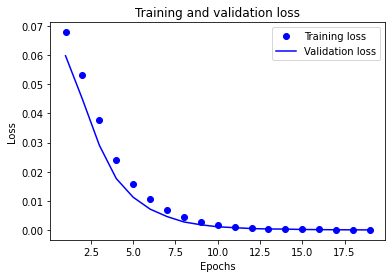

In [74]:
loss = history.history['loss'][1:] # loss for each epoch history
val_loss = history.history['val_loss'][1:]

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

As can be seen in the graph, the added hidden layer does indeed decrease the loss more rapidly (stabilizes rapidly). We will require less epochs (20) to obtain the same accuracy from now onwards. 

**Neural Network 3: three hidden layer**

In [75]:
#Set seed for reproducibility
seed(1)
tf.random.set_seed(654)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(15, activation='relu')) #input layers
model.add(Dense(10, activation='relu')) #hidden layers
model.add(Dense(10, activation='relu')) #hidden layers 
model.add(Dense(5, activation='relu')) #hidden layers
model.add(Dense(1, activation='sigmoid')) #output layer
model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy'])
early_stop = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        verbose=1, 
        patience=25)

history = model.fit(
        X_train, 
        y_train, 
        epochs=20, 
        batch_size=256, 
        validation_data=(X_test, y_test),
         callbacks=[early_stop])

Epoch 1/20
237/237 [==============================] - 1s 3ms/step - loss: 0.2105 - accuracy: 0.9629 - val_loss: 0.0593 - val_accuracy: 0.9893
Epoch 2/20
237/237 [==============================] - 1s 2ms/step - loss: 0.0545 - accuracy: 0.9893 - val_loss: 0.0483 - val_accuracy: 0.9893
Epoch 3/20
237/237 [==============================] - 1s 2ms/step - loss: 0.0444 - accuracy: 0.9893 - val_loss: 0.0378 - val_accuracy: 0.9893
Epoch 4/20
237/237 [==============================] - 1s 2ms/step - loss: 0.0340 - accuracy: 0.9893 - val_loss: 0.0278 - val_accuracy: 0.9893
Epoch 5/20
237/237 [==============================] - 1s 2ms/step - loss: 0.0238 - accuracy: 0.9893 - val_loss: 0.0190 - val_accuracy: 0.9893
Epoch 6/20
237/237 [==============================] - 1s 2ms/step - loss: 0.0158 - accuracy: 0.9917 - val_loss: 0.0118 - val_accuracy: 0.9961
Epoch 7/20
237/237 [==============================] - 1s 2ms/step - loss: 0.0098 - accuracy: 0.9959 - val_loss: 0.0068 - val_accuracy: 0.9949
Epoch 

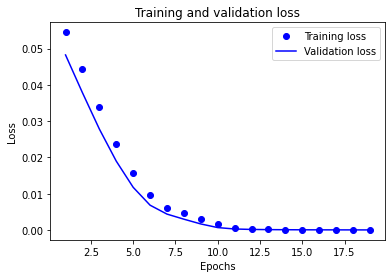

In [76]:
loss = history.history['loss'][1:] # loss for each epoch history
val_loss = history.history['val_loss'][1:]

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Finally, we can see that including a third hidden layer do not represent a significant improvement.

### 4.2 Testing different activation functions for hidden layers 

In the previous section we employed the 'relu' activation function and now we will employ the 'tanh' activation method (often used as a substitute to relu) to analyse whether the neural network performs better.

**Neural Network 4: tanh input and hidden layers**

In [77]:
#Set seed for reproducibility
seed(1)
tf.random.set_seed(654)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(15, activation='tanh')) #input layers
model.add(Dense(10, activation='tanh')) #hidden layers 
model.add(Dense(5, activation='tanh')) #hidden layers
model.add(Dense(1, activation='sigmoid')) #output layer, sigmoid renders values between 0-1
model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy'])
early_stop = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        verbose=1, 
        patience=25)

history = model.fit(
        X_train, 
        y_train, 
        epochs=20, 
        batch_size=256, 
        validation_data=(X_test, y_test),
         callbacks=[early_stop])

Epoch 1/20
237/237 [==============================] - 1s 3ms/step - loss: 0.1988 - accuracy: 0.9344 - val_loss: 0.0748 - val_accuracy: 0.9893
Epoch 2/20
237/237 [==============================] - 1s 2ms/step - loss: 0.0674 - accuracy: 0.9893 - val_loss: 0.0631 - val_accuracy: 0.9893
Epoch 3/20
237/237 [==============================] - 1s 2ms/step - loss: 0.0617 - accuracy: 0.9893 - val_loss: 0.0606 - val_accuracy: 0.9893
Epoch 4/20
237/237 [==============================] - 1s 2ms/step - loss: 0.0601 - accuracy: 0.9893 - val_loss: 0.0596 - val_accuracy: 0.9893
Epoch 5/20
237/237 [==============================] - 0s 2ms/step - loss: 0.0592 - accuracy: 0.9893 - val_loss: 0.0586 - val_accuracy: 0.9893
Epoch 6/20
237/237 [==============================] - 1s 2ms/step - loss: 0.0569 - accuracy: 0.9893 - val_loss: 0.0545 - val_accuracy: 0.9893
Epoch 7/20
237/237 [==============================] - 1s 2ms/step - loss: 0.0520 - accuracy: 0.9893 - val_loss: 0.0492 - val_accuracy: 0.9893
Epoch 

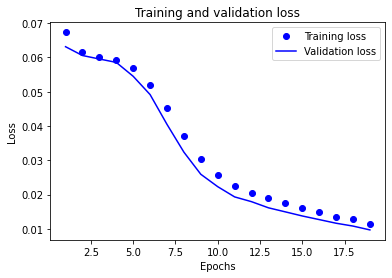

In [78]:
loss = history.history['loss'][1:] # loss for each epoch history
val_loss = history.history['val_loss'][1:]

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [79]:
predictions = model.predict_classes(X_test)

print(
        confusion_matrix(y_test,predictions), 
        '\n', 
        classification_report(y_test,predictions)
)

[[25721     0]
 [   89   190]] 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     25721
           1       1.00      0.68      0.81       279

    accuracy                           1.00     26000
   macro avg       1.00      0.84      0.90     26000
weighted avg       1.00      1.00      1.00     26000



Based on these results, we can see that "tanh" activation function worsens the accuracy of the model, requiring a higher number of epochs for convergence. Therefore, from now on we will use the structure of the *Neural Network 2*.

### 4.3 Testing different explanatory variables

For the sake of efficiency we try a subset of explanatory variables that should intuitively predict the loan default and analyse the results of the Neural Network.

These are; 
1. Amount loan 
2. Balance transaction: Balance of Account after Transaction
3. Amount transaciton: Amount of Transaction
4. A11: Unemployment rate in 1995
5. Days between: time gap between creating the account and applying for the loan

In [80]:
X1 = df_merge_7[['amount_loan','balance_trans','amount_transaction', 'A11', "days_between"]] #Define a smaller subsample of variables to predict loan default
y1 = df_merge_7['status_loan_B'] #Define loan default

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, 
                                            stratify=y, random_state=10) #Split into training and test sets

In [81]:
#Set seed for reproducibility
seed(1)
tf.random.set_seed(1234)

scaler = MinMaxScaler()
X_train1 = scaler.fit_transform(X_train1)
X_test1 = scaler.transform(X_test1)

model = Sequential()
model.add(Dense(15, activation='relu')) #input layers
model.add(Dense(10, activation='relu')) #hidden layers
model.add(Dense(5, activation='relu')) #hidden layers
model.add(Dense(1, activation='sigmoid')) #output layer
model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy'])
early_stop = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        verbose=1, 
        patience=25)

history = model.fit(
        X_train1, 
        y_train1, 
        epochs=50, 
        batch_size=256, # Higher batch size results in a higher type 2 error
        validation_data=(X_test1, y_test1),
         callbacks=[early_stop])

Epoch 1/50
237/237 [==============================] - 1s 3ms/step - loss: 0.2155 - accuracy: 0.9841 - val_loss: 0.0773 - val_accuracy: 0.9893
Epoch 2/50
237/237 [==============================] - 0s 2ms/step - loss: 0.0701 - accuracy: 0.9893 - val_loss: 0.0643 - val_accuracy: 0.9893
Epoch 3/50
237/237 [==============================] - 1s 2ms/step - loss: 0.0577 - accuracy: 0.9893 - val_loss: 0.0522 - val_accuracy: 0.9893
Epoch 4/50
237/237 [==============================] - 0s 2ms/step - loss: 0.0497 - accuracy: 0.9893 - val_loss: 0.0468 - val_accuracy: 0.9893
Epoch 5/50
237/237 [==============================] - 0s 2ms/step - loss: 0.0461 - accuracy: 0.9893 - val_loss: 0.0438 - val_accuracy: 0.9893
Epoch 6/50
237/237 [==============================] - 1s 2ms/step - loss: 0.0434 - accuracy: 0.9893 - val_loss: 0.0414 - val_accuracy: 0.9893
Epoch 7/50
237/237 [==============================] - 0s 2ms/step - loss: 0.0410 - accuracy: 0.9893 - val_loss: 0.0394 - val_accuracy: 0.9893
Epoch 

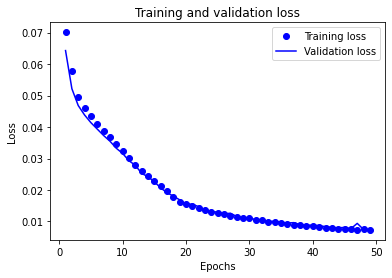

In [82]:
loss = history.history['loss'][1:] # loss for each epoch history
val_loss = history.history['val_loss'][1:]

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

After testing different specifications with our set of input (predictor) variables, we found that reducing the amount of variables led to less accuracy and efficiency. 

In [83]:
predictions = model.predict_classes(X_test1)

print(
        confusion_matrix(y_test1,predictions), 
        '\n', 
        classification_report(y_test1,predictions)
)

[[25721     0]
 [   97   182]] 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     25721
           1       1.00      0.65      0.79       279

    accuracy                           1.00     26000
   macro avg       1.00      0.83      0.89     26000
weighted avg       1.00      1.00      1.00     26000



Furthermore, we obtain that there is an increase in the error type 2 (previously non-existent): 97 false negatives out of 279 observations that defaulted.

### 4.4. Testing over and undersampling

Testing over and undersampling apart from exploring different sampling, serves as a robustness check of our neural network structure. 

**Testing sample with oversampling**

In [84]:
X_over = df_test_over[['amount_loan', 'duration_loan', 'payments_loan', 'account_to', 'amount_order',
                   'amount_transaction', "days_between", 'balance_trans', 'A4',
                   'A9', 'A10', 'A11', 'A13', 'A14',  'A16']]
y_over = df_test_over['status_loan_B']

X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, y_over, test_size=0.3, 
                                            stratify=y_over, random_state=101)

In [85]:
#Set seed for reproducibility
seed(1)
tf.random.set_seed(1894)

scaler = MinMaxScaler()
X_train_over = scaler.fit_transform(X_train_over)
X_test_over = scaler.transform(X_test_over)

model = Sequential()
model.add(Dense(15, activation='relu')) #input layers
model.add(Dense(10, activation='relu')) #hidden layers 
model.add(Dense(5, activation='relu')) #hidden layers
model.add(Dense(1, activation='sigmoid')) #output layer
model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy'])
early_stop = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        verbose=1, 
        patience=25)

history_over = model.fit(
        X_train_over, 
        y_train_over, 
        epochs=20, 
        batch_size=256, 
        validation_data=(X_test_over, y_test_over),
         callbacks=[early_stop])

Epoch 1/20
469/469 [==============================] - 1s 3ms/step - loss: 0.3942 - accuracy: 0.8802 - val_loss: 0.0612 - val_accuracy: 0.9848
Epoch 2/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0257 - accuracy: 0.9953 - val_loss: 0.0116 - val_accuracy: 0.9978
Epoch 3/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0089 - accuracy: 0.9985 - val_loss: 0.0046 - val_accuracy: 0.9990
Epoch 4/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0037 - accuracy: 0.9989 - val_loss: 0.0016 - val_accuracy: 0.9997
Epoch 5/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0013 - accuracy: 0.9999 - val_loss: 6.8381e-04 - val_accuracy: 1.0000
Epoch 6/20
469/469 [==============================] - 1s 2ms/step - loss: 5.4881e-04 - accuracy: 1.0000 - val_loss: 3.3610e-04 - val_accuracy: 1.0000
Epoch 7/20
469/469 [==============================] - 1s 2ms/step - loss: 2.8919e-04 - accuracy: 1.0000 - val_loss: 1.9025e-04 - val_acc

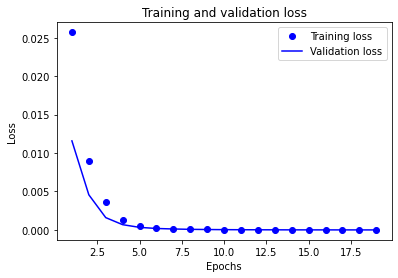

In [86]:
loss = history_over.history['loss'][1:] # loss for each epoch history
val_loss = history_over.history['val_loss'][1:]

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Using oversampling, the loss converges slightly faster than with the original dataset.

In [87]:
predictions = model.predict_classes(X_test_over)

print(
        confusion_matrix(y_test_over,predictions), 
        '\n', 
        classification_report(y_test_over,predictions)
)

[[25720     0]
 [    0 25721]] 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     25720
           1       1.00      1.00      1.00     25721

    accuracy                           1.00     51441
   macro avg       1.00      1.00      1.00     51441
weighted avg       1.00      1.00      1.00     51441



No type error 2 is found either

**Testing sample with undersampling**

In [88]:
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, test_size=0.3, 
                                            stratify=y_under, random_state=101)

In [89]:
seed(1)
tf.random.set_seed(1894)

scaler = MinMaxScaler()
X_train_under = scaler.fit_transform(X_train_under)
X_test_under = scaler.transform(X_test_under)

model = Sequential()
model.add(Dense(15, activation='relu')) #input layers
model.add(Dense(10, activation='relu')) #hidden layers 
model.add(Dense(5, activation='relu')) #hidden layers
model.add(Dense(1, activation='sigmoid')) #output layer
model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy'])
early_stop = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        verbose=1, 
        patience=25)

history_under = model.fit(
        X_train_under, 
        y_train_under, 
        epochs=50, 
        batch_size=256, 
        validation_data=(X_test_under, y_test_under),
         callbacks=[early_stop])

Epoch 1/50
6/6 [==============================] - 0s 46ms/step - loss: 0.6977 - accuracy: 0.4259 - val_loss: 0.6832 - val_accuracy: 0.5188
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 0.6766 - accuracy: 0.5127 - val_loss: 0.6644 - val_accuracy: 0.5242
Epoch 3/50
6/6 [==============================] - 0s 7ms/step - loss: 0.6601 - accuracy: 0.5403 - val_loss: 0.6487 - val_accuracy: 0.5832
Epoch 4/50
6/6 [==============================] - 0s 8ms/step - loss: 0.6450 - accuracy: 0.6055 - val_loss: 0.6334 - val_accuracy: 0.6261
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 0.6310 - accuracy: 0.6309 - val_loss: 0.6192 - val_accuracy: 0.6315
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 0.6179 - accuracy: 0.6401 - val_loss: 0.6062 - val_accuracy: 0.6512
Epoch 7/50
6/6 [==============================] - 0s 5ms/step - loss: 0.6062 - accuracy: 0.6546 - val_loss: 0.5951 - val_accuracy: 0.6816
Epoch 8/50
6/6 [=================

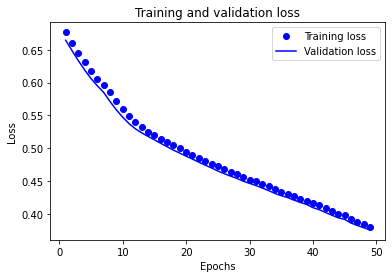

In [90]:
loss = history_under.history['loss'][1:] # loss for each epoch history
val_loss = history_under.history['val_loss'][1:]

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In this case, using undersampling leads to a less accurate model which requires a higher number of epochs.

In [91]:
predictions = model.predict_classes(X_test_over)

print(
        confusion_matrix(y_test_over,predictions), 
        '\n', 
        classification_report(y_test_over,predictions)
)

[[20670  5050]
 [    0 25721]] 
               precision    recall  f1-score   support

           0       1.00      0.80      0.89     25720
           1       0.84      1.00      0.91     25721

    accuracy                           0.90     51441
   macro avg       0.92      0.90      0.90     51441
weighted avg       0.92      0.90      0.90     51441



Unlike the cases with oversampling and the original dataset, our main specification with undersampling yields error type 1: 5050 observations were predicted as false positive (report defaulting when they do not default). This is less punishing to the balance sheet of the bank.

## 5. Bayesian analysis

In this section we introduce a bayesian analysis to understand the determinants of loan default. First we present an analysis based on simulated data, which allow us to show how a bayesian analysis works. Then, we retake the Berka dataset to perform a Bayesian analysis with real data. 

### 5.1. Bayesian analysis with simulated data
To get an idea how Bayesian analysis works, we use our &ldquo;old trick&rdquo;: generate data and then estimate a model on the generated data to see whether we can recover the true underlying parameters.


In [103]:
def generating_data(a1 = 1, a2 = -1, a3 = -3, a4 = 5, b = 5, n=100): #define function that models the data and returns dataframe
    
    #establish a normal normal distribution for the explanatory variables and noisy (error) term
    x1 = pm.Normal.dist(0,1).random(size=n) 
    x2 = pm.Normal.dist(0,1).random(size=n)
    x3 = pm.Normal.dist(0,1).random(size=n)
    x4 = pm.Normal.dist(0,1).random(size=n)
    noise = pm.Normal.dist(0,1).random(size=n)
    
    # Define y as a function of coefficient, explanatory variables and noise term
    y = b + a1 * x1 + a2 * x2 + a3 * x3 + a4 * x4 + noise
    df = pd.DataFrame({'y':y, 'x1':x1, 'x2':x2, 'x3':x3, 'x4':x4}) #Generate dataframe containing variables 
    return df

df = generating_data() #define dataframe as df

**Specifying the model**

The parameters of the model are themselves stochastic variables and we need to specify their prior distributions.

Although not necessary, it is usually convenient to bundle these samples using `az.from_pymc3()` so that you can give them a name `data_posterior_simulated_data` to refer to later on.

In [108]:
with pm.Model() as model_gen_data:
    
    # Define prior for coefficients with normal distributions
    constant = pm.Normal('constant', 0, 3)
    beta1 = pm.Normal('beta1', 0, 3)
    beta2 = pm.Normal('beta2', 0, 2)
    beta3 = pm.Normal('beta3', 0, 1.5)
    beta4 = pm.Normal('beta4', 0, 1)
    
    μ = beta1*df.x1 + beta2*df.x2 + beta3*df.x3 + beta4*df.x4 + constant #Define median for the prior distribution
    σ = pm.HalfNormal('σ',1) #Define standard deviation for prior distribution
    
    gen_obs = pm.Normal('gen_obs', μ, sigma = σ, observed = df.y) #generate observations for prior

    gen_trace = pm.sample() #generate prior for trace


with model_gen_data:
    ppc_gen_data = pm.sample_posterior_predictive(gen_trace, var_names=['gen_obs']) #Generate posterior predictive samples from a model given a trace.

#Generate posteriors
data_posterior_gen_data = az.from_pymc3(
    gen_trace,
    posterior_predictive = ppc_gen_data)

C:\Users\jart_\anaconda3\envs\tensorflow\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\jart_\anaconda3\envs\tensorflow\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\jart_\anaconda3\envs\tensorflow\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\jart_\anaconda3\envs\tensorflow\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiproces

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1359 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\jart_\anaconda3\envs\tensorflow\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


#### Trace plot and posterior 
We plot the trace using `pm.plot_trace()` and discuss what we learn from it.

First, look at the distributions on the left. Each posterior distribution is &#x2013;more or less&#x2013; centered around the values we chose when generating the data.



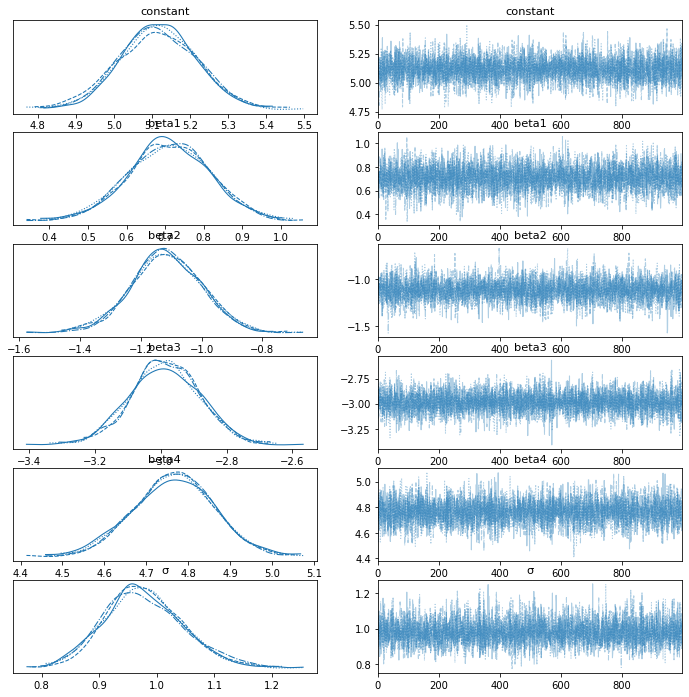

In [110]:
#Plot trace posteriors (coefficients and constant)
with model_gen_data:
    pm.plot_trace(gen_trace)

The trace plots on the right side are harder to interpret, but important in understanding whether the sampling process actually worked. First, we can highlight that the plot should seems stationary (e.g. not trending upwards or downwards). Also, there is a good mixing which translates into the condensed zig-zagging of the trace. Finally, the different chains cover the same regions.

**Summarizing the posterior distribution**

We can also summarize the posterior in a table.



In [111]:
az.summary(data_posterior_gen_data.posterior) #summary statistics for the trace posteriors

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
constant,5.117,0.102,4.932,5.313,0.001,0.001,5501.0,3173.0,1.0
beta1,0.710,0.106,0.521,0.923,0.002,0.001,4659.0,3085.0,1.0
beta2,-1.116,0.117,-1.337,-0.899,0.002,0.001,4845.0,3094.0,1.0
beta3,-2.986,0.104,-3.184,-2.795,0.001,0.001,5985.0,2982.0,1.0
beta4,4.766,0.095,4.577,4.935,0.001,0.001,5370.0,3396.0,1.0
σ,0.978,0.070,0.846,1.109,0.001,0.001,4808.0,3246.0,1.0


**Model fit**

To get an idea of the model fit, we use the posterior predictive distribution. This is the distribution of $y$ for each observation in our data. Following the lectures, we use the `numpy` function `percentile` to get the percentiles at 2.5% and 97.5%. In between these we have 95% probability mass. The vertical lines are drawn by `matplotlib`&rsquo;s function `vlines`.


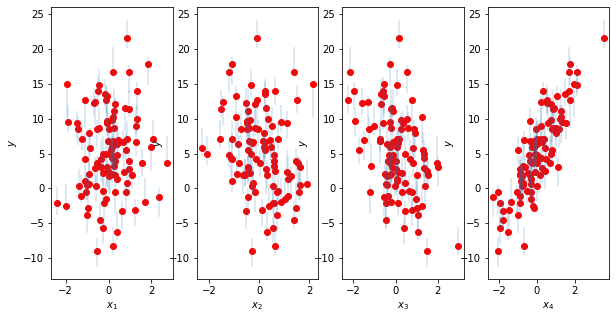

In [115]:
#Model fit plot
percentiles = np.percentile(ppc_gen_data['gen_obs'],[2.5,97.5],axis=[0]).T
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(10, 5))

ax1.vlines(df.x1,percentiles[:,0],percentiles[:,1],alpha=0.2)
ax1.scatter(df.x1,df.y, color='r')
ax1.set(xlabel='$x_1$', ylabel='$y$');

ax2.vlines(df.x2,percentiles[:,0],percentiles[:,1],alpha=0.2)
ax2.scatter(df.x2,df.y, color='r')
ax2.set(xlabel='$x_2$', ylabel='$y$');

ax3.vlines(df.x3,percentiles[:,0],percentiles[:,1],alpha=0.2)
ax3.scatter(df.x3,df.y, color='r')
ax3.set(xlabel='$x_3$', ylabel='$y$');

ax4.vlines(df.x4,percentiles[:,0],percentiles[:,1],alpha=0.2)
ax4.scatter(df.x4,df.y, color='r')
ax4.set(xlabel='$x_4$', ylabel='$y$');

The figure shows that for most observations, the observed values lie in the 95% prediction interval of the model predictions.


**In sum, we can see how the bayesian approach renders a good approximation of the true values imposed when generating the data.**

### 5.2 Bayesian analysis with real banking data

Now we will apply this Bayesian technique to real data. This gives us an opportunity to be more precise about how to choose priors for the parameters that we estimate.

In this case, we ue the ADVI method to show the variety of available ways to perform a Bayesian analysis

In [86]:
#Name variables
default = df_merge_7['status_loan_B']
amount_loan = df_merge_7['amount_loan']
balance_trans = df_merge_7['balance_trans']
amount_transaction = df_merge_7['amount_transaction']
avg_salary = df_merge_7['A11']
days_between = df_merge_7['days_between']

Since analysing default is a binary decision problem, our target in the model is assumed to follow a Bernoulli random variable with p given by a logistic function as follows: 

\begin{equation}
p = logit\left(\beta_0 + \sum_{n=1} \beta_{var}var\right)
\end{equation}

where var is the set of all variables that we use in our model and logit is the logistic function.

To build a Bayesian logistic regression model, we first have to put a prior distribution on each parameter. The choice of these priors will affect the outcome (though with more data, they probably will “converge” to the same distribution.)

Since we have no prior knowledge about these parameters, we can assume that they could be anything. In other words, we assume that all β_var follows a uniform distribution with large lower and upper bounds. In order to catch a big net, we use big lower and upper bounds for our uniform distributions.

In [124]:
#Define lower and upper bound for uniform distributions
lower=-2
higher=2
with pm.Model() as first_model:
    #priors on parameters (modelled with unifrom distributions)
    constant=pm.Uniform('constant', lower=lower, upper= higher) 
    b_amount_loan=pm.Uniform('b_amount_loan', lower=lower, upper= higher)
    b_balance_trans=pm.Uniform('b_balance_trans', lower=lower, upper= higher)
    b_amount_transaction=pm.Uniform('b_amount_transaction', lower, higher)
    b_avg_salary=pm.Uniform('b_avg_salary', lower, higher)
    b_days_between=pm.Uniform('b_days_between', lower, higher)
    
    #the probability of defaulting is a function of the chosen chaaracteristics
    p = pm.Deterministic('p', pm.math.sigmoid(constant + b_amount_loan * amount_loan +  
                                              b_balance_trans * balance_trans +  b_amount_transaction * amount_transaction 
                                              +  b_avg_salary * avg_salary + b_days_between * days_between
                                             ))


Finished [100%]: Average Loss = 2.5159e+09


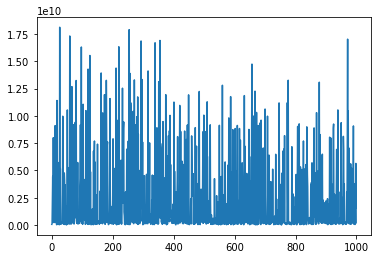

In [125]:
with first_model:
    #fit the data 
    observed=pm.Bernoulli("default_prior", p, observed=default)
    inference = pm.ADVI()
    approx = pm.fit(1000) #set for a reasonable processing time
plt.plot(approx.hist);

In [126]:
#Save trace data
with first_model:
    trace_default = approx.sample(draws=100)
trace = az.from_pymc3(trace=trace_default)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\jart_\anaconda3\envs\tensorflow\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


**Plot of the trace (distribution of estimates)**

array([[<AxesSubplot:title={'center':'constant'}>,
        <AxesSubplot:title={'center':'constant'}>],
       [<AxesSubplot:title={'center':'b_amount_loan'}>,
        <AxesSubplot:title={'center':'b_amount_loan'}>],
       [<AxesSubplot:title={'center':'b_balance_trans'}>,
        <AxesSubplot:title={'center':'b_balance_trans'}>],
       [<AxesSubplot:title={'center':'b_amount_transaction'}>,
        <AxesSubplot:title={'center':'b_amount_transaction'}>],
       [<AxesSubplot:title={'center':'b_avg_salary'}>,
        <AxesSubplot:title={'center':'b_avg_salary'}>],
       [<AxesSubplot:title={'center':'b_days_between'}>,
        <AxesSubplot:title={'center':'b_days_between'}>]], dtype=object)

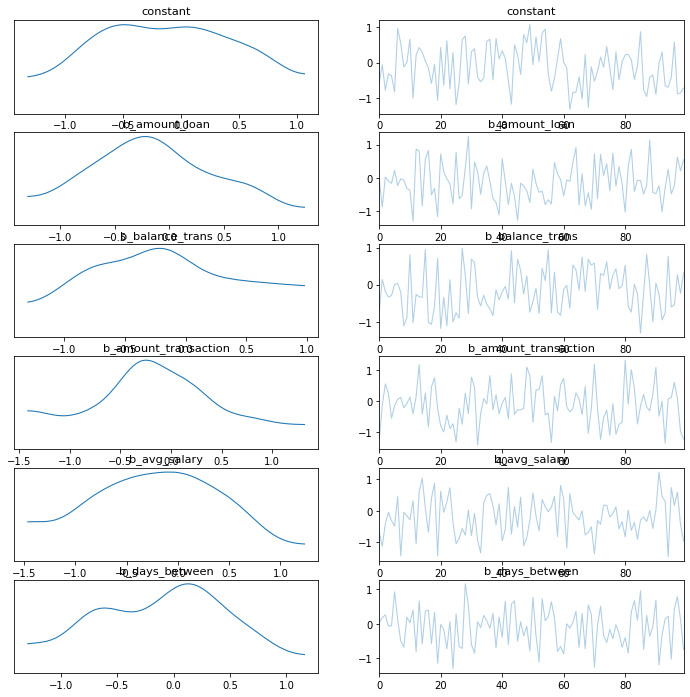

In [137]:
az.plot_trace(trace, var_names=["constant","b_amount_loan","b_balance_trans","b_amount_transaction","b_avg_salary","b_days_between"]) #Choose coefficients estimated for interpretations

The distribution of estimates shown in the trace do not provide very insightful results. All of the variables' distributions are centered on 0 and are fairly dispersed. However, the distribution of the variable "amount loan" seems to be more negative than the rest. This would imply that the bigger the loan amount, the smaller the risk of default. Likewise, the distribution of the variable "amount transaction" also follow a similar pattern. On the other hand, only the distribution of the variable "days between" indicates a possible positive effect. Accordingly, the time gap between creating the account and applying for the loan would be positively related to the possibility of making loan default.

## 6. Discussions and conclusions

Using neural networks we obtained a good predictive model for our default loan data, which has a high level of accuracy and converges with few epochs (about 10). Furthermore, it reports no type 2 errors, which is particularly important in this context given that false negatives (predicts no default when there is default) implies losses in the banks balance sheet.

In regards to our bayesian model, it does not provide strong evidence of an effect from the five variables that we selected. We therefore cannot conclude that these variables are strong determinants for predicting loan default.